In [1]:
# %load init_setup/setup.py
# ==- INITIAL SETUP -===============================================================================
import math
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interact

np.set_printoptions(formatter={'float': '{: 0.5f}'.format}, suppress = True)
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('seaborn-whitegrid')

# ==- PLOT PARAMETERS -=============================================================================
loglogalpha = 0.70
baralpha    = 0.85

plot_size = (14,8)
subplot_size = (7,4)

# ==- COLOR PALETTE -===============================================================================
c_red = "#e6194b" # red
c_gre = "#3cb44b" # green
c_yel = "#ffe119" # yellow
c_blu = "#4363d8" # blue
c_ora = "#f58231" # orange
c_pur = "#911eb4" # purple
c_cya = "#42d4f4" # cyan
c_mag = "#f032e6" # magenta
c_lim = "#bfef45" # lime
c_pin = "#fabebe" # pink
c_tea = "#469990" # teal
c_lav = "#e6beff" # lavender
c_bro = "#9A6324" # brown
c_bei = "#fffac8" # beige
c_mar = "#800000" # maroon
c_min = "#aaffc3" # mint
c_oli = "#808000" # olive
c_apr = "#ffd8b1" # apricot
c_nav = "#000075" # navy
c_gra = "#a9a9a9" # gray
c_whi = "#ffffff" # white
c_bla = "#000000" # black

accessibility_95    = [c_red, c_gre, c_blu, c_yel, c_ora, c_pur, c_cya,
                       c_mag, c_lim, c_pin, c_tea, c_lav, c_bro, c_bei,
                       c_mar, c_min, c_oli, c_apr, c_nav, c_gra, c_bla]
accessibility_99    = [c_red, c_gre, c_blu, c_yel, c_ora, c_cya, c_mag,
                       c_pin, c_tea, c_lav, c_bro, c_bei, c_mar, c_min,
                       c_nav, c_gra, c_bla]
accessibility_99_99 = [c_blu, c_yel, c_ora, c_pin, c_lav, c_mar, c_nav,
                       c_gra, c_bla]
accessibility_100   = [c_blu, c_yel, c_gra, c_bla]


In [2]:
# %load init_setup/setup2.py
matplotlib.rcParams.update({'font.size': 16})


In [3]:
# Read a file containing one array
def file_to_arr(filename):
    arr = []
    f = open(filename, "r")

    for line in f:
        meas = float(line.replace("\n", ""))
        arr.append(meas)
    
    f.close()
    return np.array(arr)

# Read a file with three rows
def file_to_arr3(filename):
    arr = []
    f = open(filename, "r")
    
    for line in f:
        meas = line.split()
        for i in range(len(meas)):
            meas[i] = float(meas[i])
        arr.append(meas)
    f.close()
    return arr
        

# Read a file containing five arrays and split them appropiately
def file_to_bfield_arrs(filename):
    measlist = {}
    f = open(filename, "r")
    
    for line in f:
        meas = (line.split())
        for i in range(len(meas)):
            meas[i] = float(meas[i])
        
        if meas[0] not in measlist:
            measlist[meas[0]] = [[meas[1]], [meas[2]], [meas[3]], [meas[4]]]
        else:
            if meas[1] not in measlist[meas[0]][0]:
                measlist[meas[0]][0].append(meas[1])
            if meas[2] not in measlist[meas[0]][1]:
                measlist[meas[0]][1].append(meas[2])
            measlist[meas[0]][2].append(meas[3])
            measlist[meas[0]][3].append(meas[4])
    
    f.close()

    return measlist

# Packs bfield data appropiately for plotting
def pack_data(orig_arr, dest_size):
    dest_arr = []
    it       = 0
    for d in orig_arr:
        if it == 0:
            dest_arr.append([d])
        else:
            dest_arr[-1].append(d)
        it += 1
        if it == dest_size:
            it = 0
    return dest_arr

# Removes the outliers from an array x considering a constant 
def remove_outliers(x, outlier_constant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlier_constant
    quartile_set = (lower_quartile - IQR, upper_quartile + IQR)
    result_list = []
    for y in a.tolist():
        if y >= quartile_set[0] and y <= quartile_set[1]:
            result_list.append(y)
    return result_list

In [13]:
mdir        = "../data/bfield_tests/"
labels      = ["real B",  "ss=100",    "ss=50",     "ss=20",     "ss=10",     "ss=5"     ]
dirs        = ["real_B/", "sim_B100/", "sim_B050/", "sim_B020/", "sim_B010/", "sim_B005/"]
h_labels    = ["real B",  "5 iterations",   "10 iterations",  "15 iterations",  "20 iterations"]
h_dirs      = ["simB_i00/","simB_i05/", "simB_i10/", "simB_i15/", "simB_i20/"]
e_dir       = "error/"
e_file1     = ["real", "intp"]
e_file2     = ["ss200", "ss100", "ss050", "ss020", "ss010", "ss005"]
B_chi2      = [[],        [],          [],          [],          [],          []         ]
B_fchi2     = []
B_fchi2_avg = []
B_ctime     = []
B_meas      = []
B_meas_sm   = []
e_real_arrs = []
e_intp_arrs = []

filenames = ["e05", "e06", "e12", "e17", "e25", "e30", "e35", "e36", "e38",
             "e40", "e44", "e48", "e52", "e55", "e57", "e60", "e63", "e67"]

for i in range(len(dirs)):
    for filename in filenames:
        B_chi2[i].append(file_to_arr(mdir + dirs[i] + filename))
    B_fchi2.append(file_to_arr(mdir + dirs[i] + "finalchi2_sample"))
    B_ctime.append(file_to_arr(mdir + dirs[i] + "e_time"))

for i in range(len(dirs)-1,-1,-1):
    for j in range(len(filenames)):
        B_fchi2[i][j] = B_fchi2[i][j] / B_fchi2[0][j]

for fchi2_arr in B_fchi2:
    avg = 0.
    for fchi2 in fchi2_arr:
        avg += fchi2
    B_fchi2_avg.append(avg/len(fchi2_arr))

B_meas.append(file_to_bfield_arrs(mdir + dirs[0]     + "meas"))
B_meas.append(file_to_bfield_arrs(mdir + dirs[2]     + "meas"))
B_meas.append(file_to_bfield_arrs(mdir + dirs[1]     + "meas"))
B_meas.append(file_to_bfield_arrs(mdir + "sim_B200/" + "meas"))

for d in dirs:
    B_meas_sm.append(file_to_bfield_arrs(mdir + d + "meas_sm"))

for e_file in e_file2:
    e_real_arrs.append(file_to_arr3(mdir + e_dir + e_file1[0] + '_' + e_file))
    e_intp_arrs.append(file_to_arr3(mdir + e_dir + e_file1[1] + '_' + e_file))

In [14]:
B_hfchi2 = []
for i in range(len(h_dirs)):
    B_hfchi2.append([])
    for filename in filenames[:6]:
        B_hfchi2[i].append(file_to_arr(mdir + h_dirs[i] + filename))

# Chi^2 error difference per KF iteration:

In [19]:
mdir        = "../data/bfield_tests/"
labels      = ["real B",  "ss=100",    "ss=50",     "ss=20",     "ss=10",     "ss=5"     ]
dirs        = ["real_B/", "sim_B100/", "sim_B050/", "sim_B020/", "sim_B010/", "sim_B005/"]
filenames   = ["e05", "e06", "e12", "e17", "e25", "e30", "e35", "e36", "e38",
               "e40", "e44", "e48", "e52", "e55", "e57", "e60", "e63", "e67"]
B_chi2      = [[], [], [], [], [], []]
B_hfchi2    = []

for i in range(len(dirs)):
    for filename in filenames:
        B_chi2[i].append(file_to_arr(mdir + dirs[i] + filename))

for i in range(len(h_dirs)):
    B_hfchi2.append([])
    for filename in filenames[:6]:
        B_hfchi2[i].append(file_to_arr(mdir + h_dirs[i] + filename))

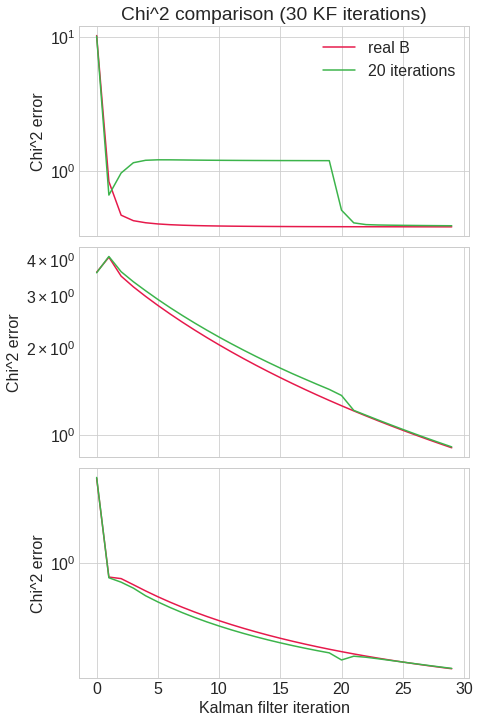

In [20]:
n_subplots = 3

ax = np.empty([n_subplots, 1])
f, ax = plt.subplots(n_subplots, 1, sharex="col", sharey="row")
f.set_size_inches((7,12))

index = np.arange(len(B_hfchi2[0][0]))
for i in range(0, n_subplots):
    ax[i].plot(index, B_hfchi2[0][i], c=c_red, label=h_labels[0])
    ax[i].plot(index, B_hfchi2[4][i], c=c_gre, label=h_labels[4])
    ax[i].set_yscale("log")
    ax[i].set_ylabel("Chi^2 error")

ax[0].set_title("Chi^2 comparison (30 KF iterations)")
ax[0].legend()
ax[2].set_xlabel("Kalman filter iteration")

f.subplots_adjust(hspace=0.05, wspace=0)
plt.show()

In [21]:
for i in range(0, n_subplots, 2):
    for j in range(len(B_hfchi2)):
        ax[int(i/2),0].plot(   index, B_hfchi2[j][int(i/2)],   c=accessibility_99[j], alpha=baralpha, label=h_labels[j])
        ax[int(i/2),1].plot(   index, B_hfchi2[j][int(i/2)+1], c=accessibility_99[j], alpha=baralpha, label=h_labels[j])
    
    # SETTINGS
    for j in range(2):
        ax[int(i/2),j].spines['right'].set_visible(False)
        ax[int(i/2),j].set_yscale("log")

ax[0,0].set_title("Chi^2 Comparison (30 KF iterations)")
ax[0,1].legend()

for i in range(int(n_subplots/2)):
    ax[i,0].set_ylabel("Chi^2 Error")
for j in range(2):
    ax[0,j].spines["top"].set_visible(False)
    ax[int(n_subplots/2 - 1), j].set_xlabel("Kalman Filter Iteration")

f.subplots_adjust(hspace=0, wspace=0)
plt.show()

IndexError: too many indices for array

In [22]:
stracks = []
stracks.append(B_chi2[1])
stracks.append(B_chi2[3])
stracks.append(B_chi2[5])
stracks.append(B_chi2[0])

In [23]:
B_chi2

[[array([ 10.27077,  0.82844,  0.46415,  0.42216,  0.40739,  0.39910,
          0.39395,  0.39053,  0.38814,  0.38640,  0.38510,  0.38410,
          0.38332,  0.38270,  0.38219,  0.38178,  0.38143,  0.38115,
          0.38090,  0.38070,  0.38052,  0.38037,  0.38023,  0.38012,
          0.38001,  0.37992,  0.37984,  0.37977,  0.37970,  0.37964,
          0.37959,  0.37954,  0.37950,  0.37946,  0.37942,  0.37938,
          0.37935,  0.37932,  0.37930,  0.37927,  0.37925,  0.37922,
          0.37920,  0.37918,  0.37917,  0.37915,  0.37913,  0.37912,
          0.37910,  0.37909,  0.37907,  0.37906,  0.37905,  0.37904,
          0.37903,  0.37902,  0.37901,  0.37900,  0.37899,  0.37898,
          0.37897,  0.37897,  0.37896,  0.37895,  0.37894,  0.37894,
          0.37893,  0.37892,  0.37892,  0.37891,  0.37891,  0.37890,
          0.37890,  0.37889,  0.37889,  0.37888,  0.37888,  0.37887,
          0.37887,  0.37887,  0.37886,  0.37886,  0.37885,  0.37885,
          0.37885,  0.37884,  0.3

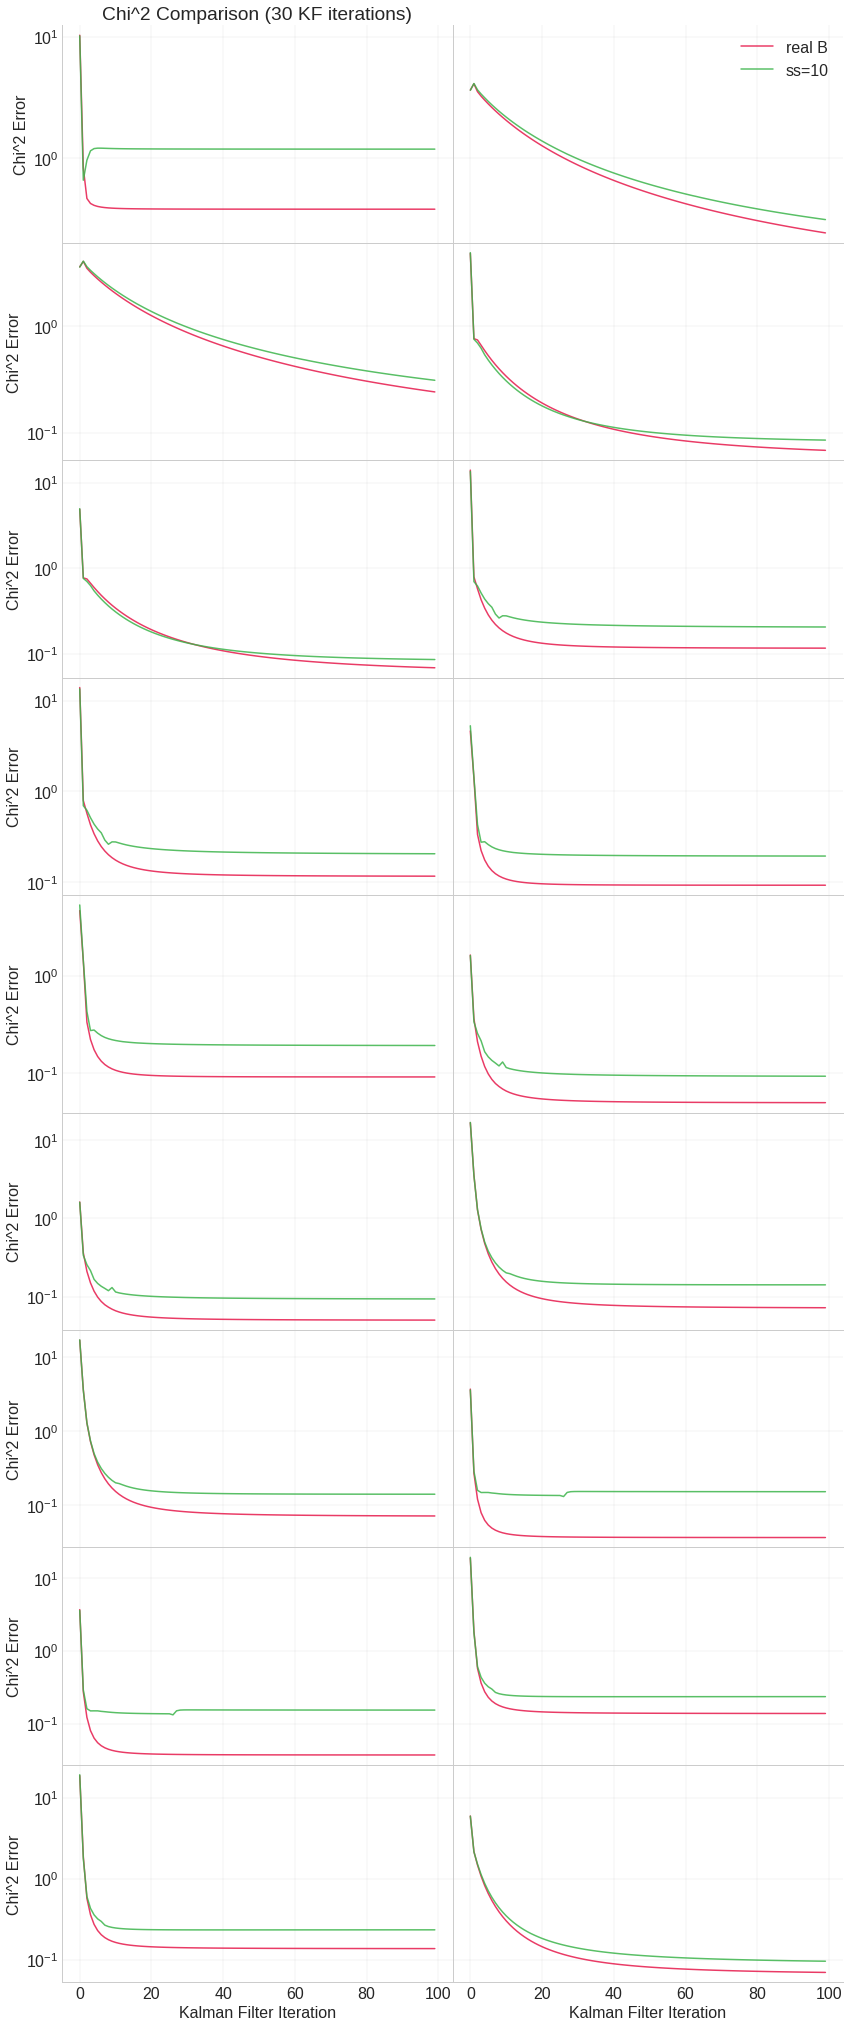

In [24]:

n_subplots = len(B_chi2[0])

ax = np.empty([int(n_subplots/2), 2])
f, ax = plt.subplots(int(n_subplots/2), 2, sharex="col", sharey="row")
f.set_size_inches((14,int(4*n_subplots/2)))

index = np.arange(len(B_chi2[0][0]))
for i in range(0, n_subplots, 2):
    for j in range(len(B_chi2)):
        if (j != 0 and j != 4): continue
        ax[int(i/2),0].plot(   index, B_chi2[j][int(i/2)],   c=accessibility_99[j%3], alpha=baralpha, label=labels[j])
        ax[int(i/2),1].plot(   index, B_chi2[j][int(i/2)+1], c=accessibility_99[j%3], alpha=baralpha, label=labels[j])
    
    # SETTINGS
    for j in range(2):
        ax[int(i/2),j].spines['right'].set_visible(False)
        ax[int(i/2),j].grid(color=c_gra, linestyle='-', linewidth=0.25, alpha=0.5)
        ax[int(i/2),j].set_yscale("log")

ax[0,0].set_title("Chi^2 Comparison (30 KF iterations)")
ax[0,1].legend()

for i in range(int(n_subplots/2)):
    ax[i,0].set_ylabel("Chi^2 Error")
for j in range(2):
    ax[0,j].spines["top"].set_visible(False)
    ax[int(n_subplots/2 - 1), j].set_xlabel("Kalman Filter Iteration")

f.subplots_adjust(hspace=0, wspace=0)
plt.show()

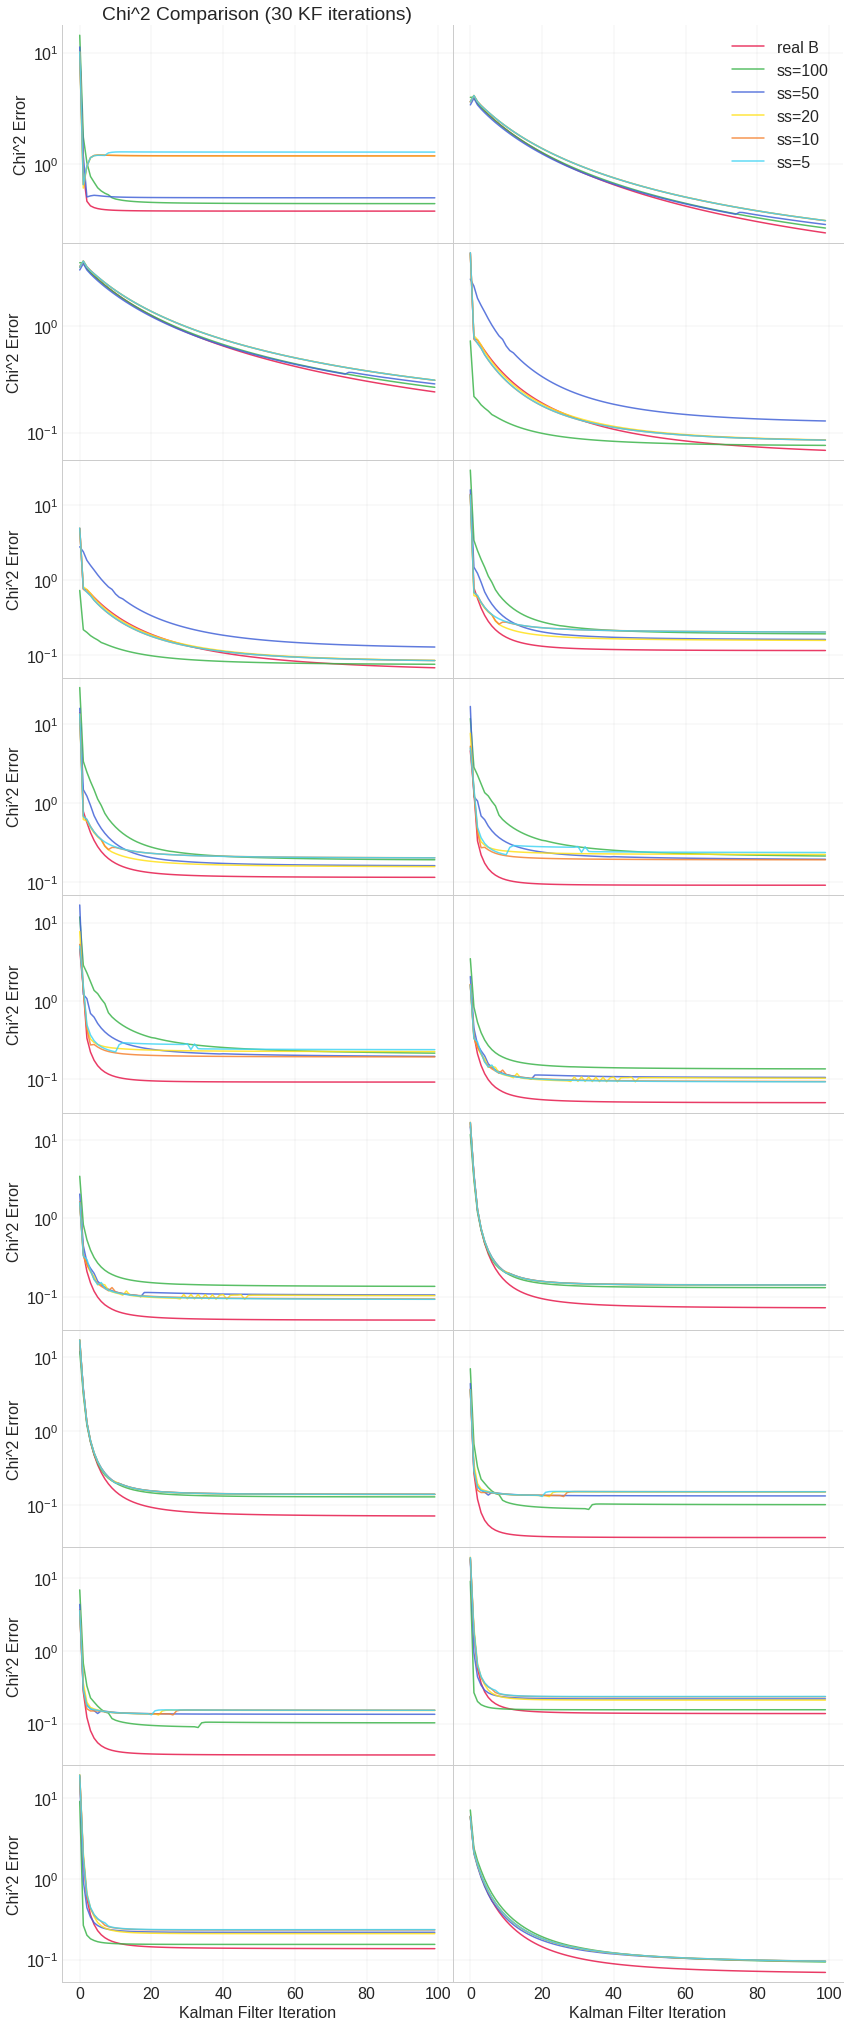

In [25]:
n_subplots = len(B_chi2[0])

ax = np.empty([int(n_subplots/2), 2])
f, ax = plt.subplots(int(n_subplots/2), 2, sharex="col", sharey="row")
f.set_size_inches((14,int(4*n_subplots/2)))

index = np.arange(len(B_chi2[0][0]))
for i in range(0, n_subplots, 2):
    for j in range(len(B_chi2)):
        ax[int(i/2),0].plot(   index, B_chi2[j][int(i/2)],   c=accessibility_99[j], alpha=baralpha, label=labels[j])
        ax[int(i/2),1].plot(   index, B_chi2[j][int(i/2)+1], c=accessibility_99[j], alpha=baralpha, label=labels[j])
    
    # SETTINGS
    for j in range(2):
        ax[int(i/2),j].spines['right'].set_visible(False)
        ax[int(i/2),j].grid(color=c_gra, linestyle='-', linewidth=0.25, alpha=0.5)
        ax[int(i/2),j].set_yscale("log")

ax[0,0].set_title("Chi^2 Comparison (30 KF iterations)")
ax[0,1].legend()

for i in range(int(n_subplots/2)):
    ax[i,0].set_ylabel("Chi^2 Error")
for j in range(2):
    ax[0,j].spines["top"].set_visible(False)
    ax[int(n_subplots/2 - 1), j].set_xlabel("Kalman Filter Iteration")

f.subplots_adjust(hspace=0, wspace=0)
plt.show()

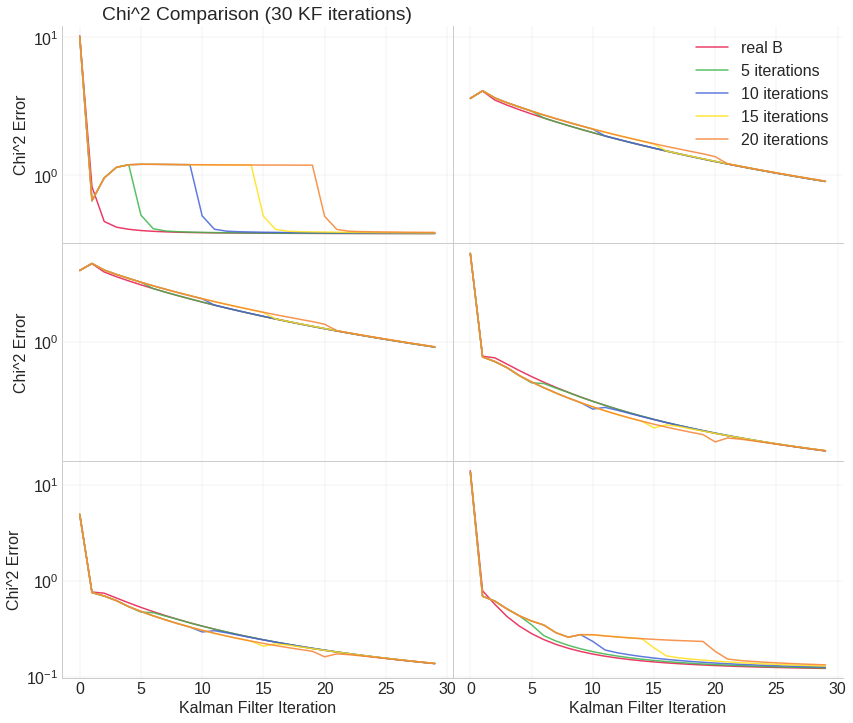

In [26]:
n_subplots = len(B_hfchi2[0])

ax = np.empty([int(n_subplots/2), 2])
f, ax = plt.subplots(int(n_subplots/2), 2, sharex="col", sharey="row")
f.set_size_inches((14,int(4*n_subplots/2)))

index = np.arange(len(B_hfchi2[0][0]))
for i in range(0, n_subplots, 2):
    for j in range(len(B_hfchi2)):
        ax[int(i/2),0].plot(   index, B_hfchi2[j][int(i/2)],   c=accessibility_99[j], alpha=baralpha, label=h_labels[j])
        ax[int(i/2),1].plot(   index, B_hfchi2[j][int(i/2)+1], c=accessibility_99[j], alpha=baralpha, label=h_labels[j])
    
    # SETTINGS
    for j in range(2):
        ax[int(i/2),j].spines['right'].set_visible(False)
        ax[int(i/2),j].grid(color=c_gra, linestyle='-', linewidth=0.25, alpha=0.5)
        ax[int(i/2),j].set_yscale("log")

ax[0,0].set_title("Chi^2 Comparison (30 KF iterations)")
ax[0,1].legend()

for i in range(int(n_subplots/2)):
    ax[i,0].set_ylabel("Chi^2 Error")
for j in range(2):
    ax[0,j].spines["top"].set_visible(False)
    ax[int(n_subplots/2 - 1), j].set_xlabel("Kalman Filter Iteration")

f.subplots_adjust(hspace=0, wspace=0)
plt.show()

# Final Chi^2 error difference

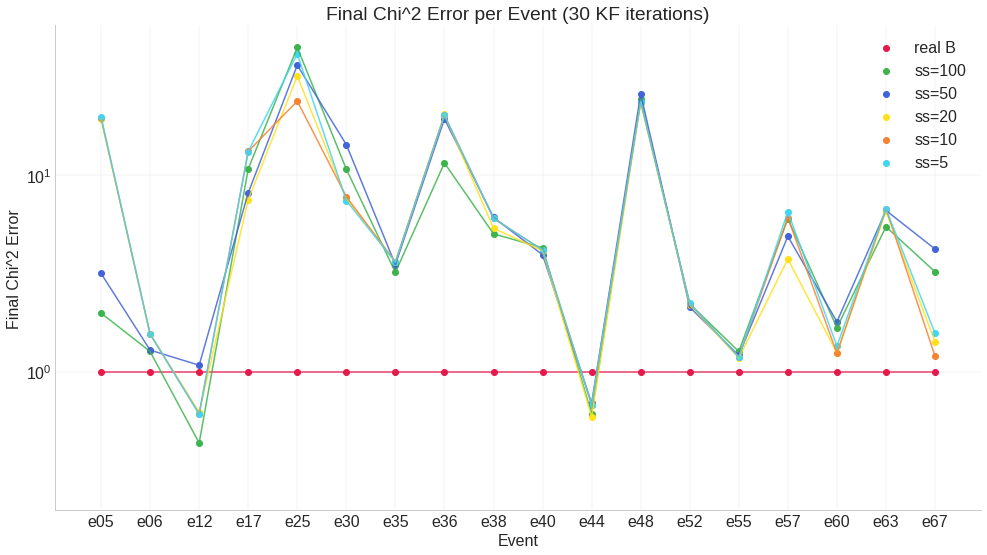

In [27]:
fig, ax = plt.subplots()

fig.set_size_inches(plot_size)
index = np.arange(len(B_fchi2[0]))

for i in range(len(B_fchi2)):
    ax.scatter(index, B_fchi2[i], c=accessibility_99[i], label=labels[i])
    ax.plot(   index, B_fchi2[i], c=accessibility_99[i], alpha=baralpha)

plt.xlabel("Event")
plt.ylabel("Final Chi^2 Error")
plt.title("Final Chi^2 Error per Event (30 KF iterations)")
plt.xticks(index, filenames)
plt.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yscale("log")
ax.grid(color=c_gra, linestyle='-', linewidth=0.25, alpha=0.5)

plt.tight_layout()
plt.show()

In [42]:
def plot_b(b, density):
    x, y = np.meshgrid(b[0][0], b[0][1])
    bx = []
    by = []
    f, axes = plt.subplots(nrows=int(len(b)/2), ncols=2, sharex="col", sharey="row", figsize=(14,7))
    
    for i in range(len(b)):
        bx.append(np.array(pack_data(b[i][2], len(b[i][1]))))
        by.append(np.array(pack_data(b[i][3], len(b[i][1]))))
        axes[i].streamplot(x, y, bx[i], by[i], density=density, color=accessibility_99[i])
    axes[0].set_title("Real Magnetic Field")
    axes[1].set_title("Interpolated Magnetic Field")
    axes[0].set_ylabel("y")
    axes[0].set_xlabel("x")
    axes[1].set_xlabel("x")
    axes[0].set_xticks(np.arange(-200, 201, 100))
    axes[0].set_yticks(np.arange(-200, 201, 100))
    axes[1].set_xticks(np.arange(-200, 201, 100))
    axes[1].set_yticks(np.arange(-200, 201, 100))
#     plt.tight_layout()
    f.subplots_adjust(hspace=0, wspace=0.05)
    plt.show()
    return

def show_time(z=200.):
    plot_b([B_meas[0][z], B_meas[1][z]], 2)

interact(show_time, z=(200., 600., 10.))

interactive(children=(FloatSlider(value=200.0, description='z', max=600.0, min=200.0, step=10.0), Output()), _…

<function __main__.show_time(z=200.0)>

In [29]:
def show_time(z=200.):
    plot_b([B_meas_sm[0][z], B_meas_sm[1][z], B_meas_sm[2][z], B_meas_sm[3][z], B_meas_sm[4][z], B_meas_sm[5][z]], 2)

interact(show_time, z=(200., 600., 10.))

interactive(children=(FloatSlider(value=200.0, description='z', max=600.0, min=200.0, step=10.0), Output()), _…

<function __main__.show_time(z=200.0)>

In [30]:
mdir        = "data/bfield_tests/"
dirs        = ["real_B/", "sim_B200/", "sim_B100/", "sim_B050/", "sim_B020/", "sim_B010/", "sim_B005/"]

B_fchi2     = []

for dir in dirs:
    B_fchi2.append(file_to_arr(mdir + dir + "finalchi2_e1000"))

B_fchi2_clean = []
for arr in B_fchi2:
    B_fchi2_clean.append(remove_outliers(arr, 3))

B_fchi2_avg = []
for arr in B_fchi2_clean:
    B_fchi2_avg.append(np.average(arr))

for i in range(len(B_fchi2_avg)-1,-1,-1):
    B_fchi2_avg[i] = B_fchi2_avg[i]/B_fchi2_avg[0]

FileNotFoundError: [Errno 2] No such file or directory: 'data/bfield_tests/real_B/finalchi2_e1000'

# Chi^2 Error Distribution

In [ ]:
f, axes = plt.subplots(nrows=len(B_fchi2), ncols=2)
f.set_size_inches((14,int(4*len(B_fchi2))))

for i in range(len(B_fchi2)):
    axes[i, 0].hist(B_fchi2[i],       bins = 200, color=accessibility_99[i])
    axes[i, 1].hist(B_fchi2_clean[i], bins = 200, color=accessibility_99[i])

for i in range(len(axes)):
    for j in range(len(axes[i])):
        axes[i,j].spines['top'].set_visible(False)
        axes[i,j].spines['right'].set_visible(False)
        axes[i,j].grid(color=c_gra, linestyle='-', linewidth=0.25, alpha=0.5)

plt.tight_layout()

plt.show()

# Interpolation Accuracy vs Time

In [ ]:
colors = [c_bla, c_mar, c_red, c_pin, c_mar, c_red, c_pin, c_mar, c_red, c_pin, 
          c_mar, c_red, c_pin, c_mar, c_red, c_pin, c_mar, c_red, c_pin]
markers = ["P",   "v",   "v",   "v",   "o",   "o",   "o",   "s",   "s",   "s",
           "*",   "*",   "*",   "D",   "D",   "D",   "p",   "p",   "p"]
names = ["realB",          "simB_ss200r400", "simB_ss200r200", "simB_ss200r100", 
         "simB_ss100r400", "simB_ss100r200", "simB_ss100r100", "simB_ss050r400", 
         "simB_ss050r200", "simB_ss050r100", "simB_ss020r400", "simB_ss020r200", 
         "simB_ss020r100", "simB_ss010r400", "simB_ss010r200", "simB_ss010r100",
         "simB_ss005r400", "simB_ss005r200", "simB_ss005r100"]
avg_fchi2 = [1.,                 122.59054174746021, 122.59054174746021, 122.59054174746021, 
             1.7330013222060718, 1.7330013222060718, 1.7330013222060718, 1.4190169657940002, 
             1.4190169657940002, 1.4190169657940002, 1.4136513546121674, 1.4136513546121674,
             1.4136513546121674, 1.3822203302209861, 1.3822203302209861, 1.3822203302209861,
             1.3829756488152811, 1.3829756488152811, 1.3829756488152811]
total_time = [113.63, 123.74, 110.53, 106.63, 108.56,  98.61,  96.31, 106.13, 107.14, 105.30, 
              102.24, 106.97, 107.85,  96.78,  96.30, 105.28,1048.30, 105.20, 101.79]
tracks_dropped = [126,  2,  0, 88, 26, 27, 66, 99, 98,127, 71, 68, 79, 63, 70, 75, 80, 71, 90]

In [ ]:
def scatter_plot(ttime, fchi2, colors, markers, labels, scale="log"):
    fig, ax = plt.subplots()
    fig.set_size_inches((14,9))

    for i in range(len(names)):
        ax.scatter(ttime[i], fchi2[i], c=colors[i], s=80, label=labels[i], marker=markers[i])
    plt.xscale(scale)
    plt.xlabel("total time")
    plt.yscale(scale)
    plt.ylabel("avg. chi^2 error / real chi^2 error")
    plt.legend()
    plt.show()
    
    return

In [ ]:
scatter_plot(total_time, avg_fchi2, colors, markers, names, "linear")

In [ ]:
remove = [16, 3, 2, 1]

for i in remove:
    colors.pop(i)
    markers.pop(i)
    names.pop(i)
    avg_fchi2.pop(i)
    total_time.pop(i)
    tracks_dropped.pop(i)

In [ ]:
scatter_plot(total_time, avg_fchi2, colors, markers, names, "linear")

In [ ]:
for i in range(len(e_real_arrs)):
    e_real_arrs[i] = np.ndarray.flatten(np.array(e_real_arrs[i]))
    e_intp_arrs[i] = np.ndarray.flatten(np.array(e_intp_arrs[i]))

In [ ]:
e_sum = []

for i in range(len(e_real_arrs)):
    e_sum.append(0)
    for j in range(len(e_real_arrs[i])):
        if e_real_arrs[i][j] != 0:
            e_sum[i] += (np.abs(e_real_arrs[i][j] - e_intp_arrs[i][j]))/np.abs((e_real_arrs[i][j]))
    e_sum[i] /= len(e_real_arrs[i])


In [ ]:
for err in e_sum:
    print(err)